# Tutorial: Binary Intrinsic Dimension

## BID summary:

For non interacting random bit streams of length $N$ it is possible to write the exact probability of observing Hamming distance 
$r = |\boldsymbol{\sigma}-\boldsymbol{\sigma}'|_H 
%=\frac{N-\boldsymbol{\sigma} \cdot \boldsymbol{\sigma}}{2}
$ between two i.i.d samples $\boldsymbol{\sigma}$ and $\boldsymbol{\sigma}'$ as 

\begin{equation}
P_0(r) = \frac{1}{2^N} \binom{N}{r}. \tag{1}
\end{equation}

For interacting spins, our model generalizes the previous expression to 

\begin{equation}
P(r)=C\frac{1}{2^{d(r)}}\binom{d(r)}{r}, \tag{2}
\end{equation}
where $C$ is the normalization constant. Eq. 2 reduces to 1
for $ d(r) = N$ and $C=1$. We empirically found that model 2 fits accurately the observed distributions, at least for small distances, if one retains the first two terms of the Taylor expansion:
\begin{equation}
    d(r)=d_0+d_1 \, r \tag{3}
\end{equation}
where $d_0$ and $d_1$ are variational parameters.
In order to infer them
we minimize the Kullbac-Leibler divergence between the empirical probability of Hamming distances $P_{emp}(r)$ and the model $P(r)$ given by Eqs. 2 and 3, 

\begin{equation}
    D_{KL}(P_{emp}||P) = \sum_{r \leq r_{max}} P_{emp}(r) \log{\frac{P_{emp}(r)}{P(r)}}, \tag{4}
\end{equation}
where $r_{max}$ is a meta-parameter that allows constraining the fit to small distance if necessary ( i.e., we discard distances $r>r_{max}$ from $P_{emp}$, we show an example below).
We fix $r_{max}$ by taking it as the quantile of order $\alpha_{max}$ of $P_{emp}$, meaning

\begin{equation}
\alpha_{max} = \sum_{r=0}^{r_{max}} P_{emp}(r), \tag{5}
\end{equation}
where $\alpha_{max} \in [0,1]$. Ideally nothing depends qualitatively on $\alpha_{max}$.


### NOTE: 

In the paper we call $\alpha^* \equiv \alpha_{max}$ and $r^* \equiv r_{max}$.

In practice we also define $\alpha_{min}$ and $r_{min}$ by  

\begin{equation}
\alpha_{min} = \sum_{r=0}^{r_{min}} P_{emp}(r), \tag{6}
\end{equation}
which allow to remove small distances (those with $r<r_{min}$) from $P_{emp}$. These distances sometimes bring problems to the minimization of (4), for example when the histogram is poorly sampled in that regime. 


## Measuring the BID of random bits:


For $N$ random spins the BID coincides with the number of variables. The solution for $P(r)$ is exactly Eq. (1) and thus the optimization of (4) must give $d_0=N$ and $d_1=0$.

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt

# this environmental variable must be set <before> the BID imports, to work with JAX double-precision
os.environ["JAX_ENABLE_X64"] = "True"
from dadapy.hamming import BID, Hamming

# REPRODUCIBILITY
seed = 1
np.random.seed(seed=seed)

In [38]:
# RANDOM DATA
L = 100  # number of bits
Ns = 5000  # number of samples

# FORMAT NOTE: spins must be normalized to +-1
X = (2 * np.random.randint(low=0, high=2, size=(Ns, L)) - 1) # X.shape=(Ns,L)

In [39]:
# DEFINING COORDINATES
H = Hamming(coordinates=X)

# COMPUTING DISTANCES
H.compute_distances() # stores the matrix of distances between samples in H.distances of shape (Ns,Ns)

# COMPUTING AND SAVING HISTOGRAM OF DISTANCES
histfolder = f'datasets/hamming/random_spins/L{L}/hist/'
filename = f'counts.txt'
H.D_histogram(compute_flag=1,            # if 0 the histograms are loaded instead of computed
              save=True,                 # we compute the histograms once and save time in the future
              resultsfolder=histfolder,  # folder where the histograms are saved
              filename=filename, 
              )

# "H.D_histograms" defines the following attributes
idx = 5
print(f'{H.D_values[:idx]=}')  # vector containing the sampled distances
print(f'{H.D_counts[:idx]=}')  # vector containing how many times each distance was sampled
print(f'{H.D_probs[:idx]=}')   # same as "D_counts" but normalized by the total number of counts observed 

H.D_values[:idx]=array([25, 26, 27, 28, 29], dtype=int32)
H.D_counts[:idx]=array([  4,   6,  34,  52, 120])
H.D_probs[:idx]=array([3.20e-07, 4.80e-07, 2.72e-06, 4.16e-06, 9.60e-06])


### OPTIMIZATION

(See paper supp. inf for short description about the stochastic optimization performed)

In [40]:
# PARAMETER DEFINITIONS FOR OPTIMIZATION
alphamin = 0        # order of min_quantile, to remove poorly sampled parts of the histogram if necessary (see Supp. Inf. of paper)
alphamax = 1        # order of max_quantile, to define r* (named rmax in the code).
delta = 5e-3        # stochastic optimization step size
Nsteps = int(1e5)   # number of optimization steps
export_results = 1  # flag to export d0,d1,logKL,Pemp,Pmodel after optimization (default=1)
export_logKLs = 1   # flag to export the logKLs during optimization (default=0)
optfolder0 = f"datasets/hamming/random_spins/L{L}/opt/"  # folder where optimization results are saved

B = BID(
    H=H,
    alphamin=alphamin,
    alphamax=alphamax,
    seed=seed,
    delta=delta,
    Nsteps=Nsteps,
    export_results=export_results,
    export_logKLs=export_logKLs,
    optfolder0=optfolder0,
    L=L,
)

B.computeBID()  # results are defined as attributes of B. They are also exported if export_results=1 (default)

print('')
print(f'{B.d0=}')
print(f'{B.d1=}')
print(f'{B.logKL=}')
print(f'{B.rmax=}')

starting optimization
optimization took 0.0 minutes
d_0=99.574,d_1=0.008,logKL=-10.85

B.d0=99.57444692619558
B.d1=0.008277386221249374
B.logKL=-10.85470780641487
B.rmax=76


### explicit model validation: 

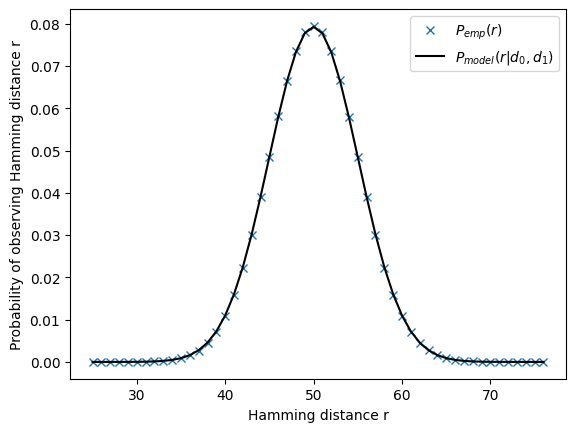

In [47]:
fig,ax = plt.subplots(1)

# empirical distribution of distances
ax.plot(B.remp,
        B.Pemp,
        'x',
        label=r'$P_{emp}(r)$',
        )
# model fit
ax.plot(B.remp,
        B.Pmodel,
        '-',
        color='black',
        label=r'$P_{model}(r|d_0,d_1)$',
        )
plt.ylabel('Probability of observing Hamming distance r')
plt.xlabel('Hamming distance r')
plt.legend()
plt.show()

### KL during optimization

Note that only random moves that minimize (4) are taken, and the rest are discarded. The following plot shows a subsampling of the proposed moves made by the optimizer. 

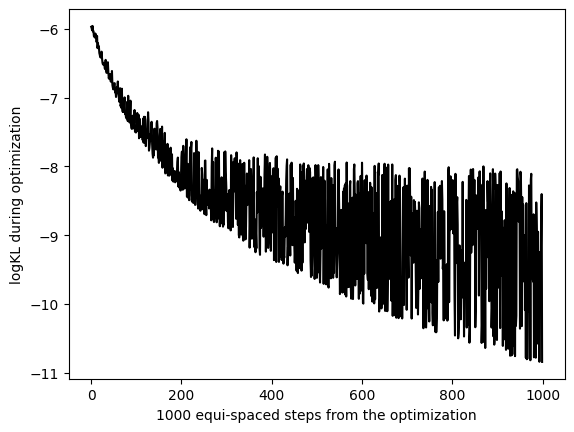

In [50]:
logKLs_opt = B.Op.logKLs # also importable by logKLs_opt = B.load_logKLs_opt()
figKL,axKL = plt.subplots()
axKL.plot(logKLs_opt,
          color='black',
          )
plt.ylabel('logKL during optimization')
plt.xlabel('1000 equi-spaced steps from the optimization')
plt.show()